In this group of notebook we will test the methods implemented in the library to check if they can improve the results of the models.

In order to be as impartial as possible, we will use a KFold evaluation for each combination, with a k-value of five.

In this particular notebook, we will train the model using the `CutMixRandom` technique.

In [ ]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

from semantic_segmentation_augmentations.holemakertechnique import HoleMakerRandom
from semantic_segmentation_augmentations.holesfilling import CutMixRandom

from vision_models_evaluation.core import evaluate

from sklearn.model_selection import KFold

import pandas as pd

import matplotlib.pyplot as plt

import PIL
import torchvision.transforms as transforms
from pathlib import Path
import random

/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Then, we prepare the scenario: we are going to use a grape vine dataset where the semantic problem to tackle is to segmentate the RGB images into wood, leaves, grape and pole classes.

Finally, we define here the mapping functions and the masks transformations.

In [ ]:
path=Path('dataset/')
path_images = path/"Images"
path_labels = path/"Labels"

def get_y_fn(x):
    return Path(str(x).replace("Images","Labels").replace("color","gt").replace(".jpg",".png"))

codes = np.loadtxt(path/'codesAll.txt', dtype=str)

from albumentations import (
  Compose,
  OneOf,
  ElasticTransform,
  GridDistortion, 
  OpticalDistortion,
  HorizontalFlip,
  Rotate,
  Transpose,
  CLAHE,
  ShiftScaleRotate
)

class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0

    def __init__(self, aug): 
        self.aug = aug

    def encodes(self, x):
        img, mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

transforms=Compose([HorizontalFlip(p=0.5),
                    Rotate(p=0.40,limit=10),GridDistortion()
                    ],p=1)

transformPipeline=SegmentationAlbumentationsTransform(transforms)

class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        if len(x) == 2:
            img, mask = x
        elif len(x) == 1:
            img = x[0]
            mask = np.zeros_like(img)

        #Convert to array
        mask = np.array(mask)

        # background = 0, leaves = 1, pole = 74 o 76, wood = 25 o 29, grape = 255
        mask[mask == 255] = 1 # grape
        mask[mask == 150] = 2 # leaves
        mask[mask == 76] = 3 ; mask[mask == 74] = 3 # pole
        mask[mask == 29] = 4 ; mask[mask == 25] = 4 # wood
        mask[mask >= 5] = 0 # resto: background

        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask
    
def decodes(mask):
    shape = mask.shape
    _mask = np.empty([*shape, 3])
    grape_c = np.array([255, 255, 255])
    leaves_c = np.array([0, 255, 0])
    pole_c = np.array([255, 0, 0])
    wood_c = np.array([0, 0, 255])
    back_c = np.array([0, 0, 0])
    
    for j in range(shape[0]):
        for i in range(shape[1]):
            if mask[j, i] == 1:
                _mask[j, i] = grape_c
            elif mask[j, i] == 2:
                _mask[j, i] = leaves_c
            elif mask[j, i] == 3:
                _mask[j, i] = pole_c
            elif mask[j, i] == 4:
                _mask[j, i] = wood_c
            else:
                _mask[j, i] = back_c
    
    return _mask.astype(np.uint8)

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

While training, we will use the EarlyStopping strategy: after five epoch without improvements, the training will be stopped.

In [ ]:
esc = EarlyStoppingCallback(patience = 5, min_delta = 0.01)

Then, we define all the hparams (hyperparameters) to build the datablocks, dataloaders and learners.

In [ ]:
db_hparams = {
    "blocks": (ImageBlock, MaskBlock(codes)),
    "get_items": get_image_files,
    "get_y": get_y_fn,
    "splitter": RandomSplitter(valid_pct=0.2),
    "item_tfms": [Resize((480,640)), TargetMaskConvertTransform(), transformPipeline],
    "batch_tfms": Normalize.from_stats(*imagenet_stats)
}

dls_hparams = {
    "source": path_images,
    "bs": 2,
    "pin_memory": False
}

technique = KFold(n_splits = 5)

learner_hparams = {
    "arch": resnet50,
    "pretrained": True,
    "metrics": [DiceMulti()],
    "cbs": []
}

learning_hparams = {
    "epochs": 30,
    "base_lr": 0.001,
    "freeze_epochs": 3
}

learning_mode = "finetune"

saving_hparams = {
    "save_best": True,
    "metric": "DiceMulti",
    "model_name": "CutMixRandom"
}

In order to know how does this technique work, we can show an example:

This technique removes all the information inside a selected region.

/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (training) that exists in the learner. Use `self.learn.training` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


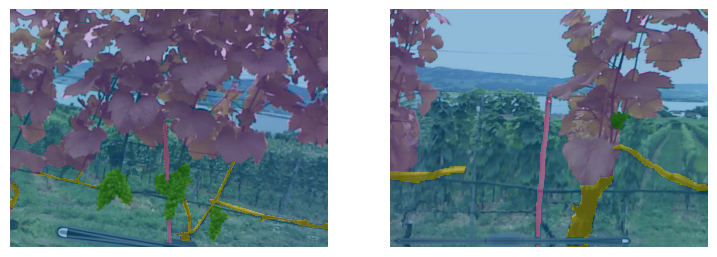

In [ ]:
cmr = CutMixRandom(holes_num = 2, hole_maker = HoleMakerRandom((250, 250)), p = 1)
dls = DataBlock(**db_hparams).dataloaders(**dls_hparams)
with Learner(dls, resnet50(), metrics=[DiceMulti()], cbs = cmr) as learn:
    learn.epoch, learn.training = 0, True
    learn.dl = dls.train
    b = dls.one_batch()
    learn._split(b)
    learn('before_train')
    learn('before_batch')

_, axs = plt.subplots(1, 2, figsize=(9, 9))
dls.show_batch(b = (cmr.x, cmr.y), ctxs = axs.flatten())

Finally, we test the model with distinct hparams.

In [ ]:
results = {}

for holes_num in [1, 2]:
    for size in [(100, 100), (200, 200), (300, 300)]:
            cmr = CutMixRandom(holes_num = holes_num, hole_maker = HoleMakerRandom(size))
            learner_hparams["cbs"] = [esc, cmr]
            r = evaluate(db_hparams,
                         dls_hparams,
                         technique,
                         learner_hparams,
                         learning_hparams,
                         learning_mode,
                         saving_hparams,
                         verbose = True
                        )
            results.update({
                str(holes_num) + str(size): r["DiceMulti"]
            })

Starting the training for a new model
Training the fold 1


/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,dice_multi,time
0,1.050655,0.796145,0.281091,00:21
1,0.746513,0.438341,0.419465,00:19
2,0.600597,0.550792,0.325271,00:19


epoch,train_loss,valid_loss,dice_multi,time
0,0.391896,0.390919,0.552046,00:20
1,0.366308,0.342008,0.693591,00:19
2,0.341308,0.330037,0.699702,00:19
3,0.326701,0.333543,0.714216,00:19
4,0.307564,0.336852,0.737605,00:19
5,0.301162,0.320538,0.723479,00:19
6,0.290818,0.313566,0.749519,00:19
7,0.282968,0.354349,0.758036,00:19
8,0.283563,0.297304,0.775230,00:19
9,0.285399,0.310060,0.764685,00:20


No improvement since epoch 8: early stopping


Test results for the model.   validation: 0.2685135006904602  /  DiceMulti: 0.8332662079973175  
Saving best model because DiceMulti 0.8333 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,1.037476,0.886493,0.296496,00:19
1,0.853440,0.582458,0.342522,00:19
2,0.817070,0.541904,0.340208,00:19


epoch,train_loss,valid_loss,dice_multi,time
0,0.473540,0.449175,0.412353,00:20
1,0.442598,0.439475,0.408233,00:20
2,0.416771,0.330759,0.636946,00:20
3,0.392268,0.332023,0.609360,00:20
4,0.362063,0.295100,0.747644,00:20
5,0.339855,0.285815,0.736384,00:20
6,0.326090,0.272567,0.778877,00:20
7,0.319533,0.259126,0.793924,00:20
8,0.317664,0.277113,0.791646,00:20
9,0.299766,0.268329,0.795731,00:20


No improvement since epoch 7: early stopping


Test results for the model.   validation: 0.23490644991397858  /  DiceMulti: 0.8231831967603578  
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.850468,0.451336,0.350931,00:19
1,0.644943,0.415319,0.367501,00:19
2,0.769949,0.661987,0.285845,00:19


epoch,train_loss,valid_loss,dice_multi,time
0,0.478063,0.375738,0.468338,00:20
1,0.416747,0.352273,0.600356,00:20
2,0.392965,0.346960,0.629461,00:20
3,0.370902,0.313410,0.700359,00:19
4,0.357373,0.340142,0.627399,00:19
5,0.333697,0.290894,0.767931,00:20
6,0.317439,0.318530,0.745380,00:19
7,0.307497,0.295475,0.778660,00:20
8,0.293414,0.300264,0.724048,00:20
9,0.281244,0.285846,0.775921,00:20


No improvement since epoch 10: early stopping


Test results for the model.   validation: 0.1924811452627182  /  DiceMulti: 0.8637092969092313  
Saving best model because DiceMulti 0.8637 >= 0.8333.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,1.012029,0.764168,0.341252,00:19
1,0.698836,0.566194,0.381207,00:19
2,0.923221,0.635436,0.325464,00:19


epoch,train_loss,valid_loss,dice_multi,time
0,0.547864,0.360364,0.419930,00:20
1,0.479271,0.310434,0.447954,00:20
2,0.425283,0.275526,0.629816,00:20
3,0.404296,0.294948,0.551746,00:20
4,0.379002,0.269351,0.764003,00:20
5,0.356334,0.260850,0.741231,00:20
6,0.331422,0.230119,0.811727,00:20
7,0.313412,0.228546,0.799289,00:20
8,0.303701,0.234817,0.775934,00:20
9,0.296263,0.256832,0.808098,00:20


No improvement since epoch 6: early stopping


Test results for the model.   validation: 0.23213060200214386  /  DiceMulti: 0.7824987665349799  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,1.066500,0.755599,0.327438,00:19
1,0.839217,0.789722,0.321095,00:19
2,0.690000,0.490319,0.364772,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.434343,0.422173,0.409383,00:20
1,0.399397,0.353380,0.554316,00:20
2,0.369116,0.355340,0.608246,00:20
3,0.352702,0.304890,0.752514,00:20
4,0.352723,0.298667,0.715276,00:20
5,0.323640,0.276276,0.774295,00:20
6,0.310713,0.292161,0.747112,00:20
7,0.296587,0.274389,0.782134,00:20
8,0.288824,0.260910,0.812043,00:20
9,0.274632,0.261680,0.799921,00:20


No improvement since epoch 10: early stopping


Test results for the model.   validation: 0.22099633514881134  /  DiceMulti: 0.813905748264417  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.902733,0.559130,0.337362,00:20
1,0.606229,0.458552,0.410402,00:20
2,0.550667,0.695026,0.361340,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.376377,0.497013,0.622924,00:21
1,0.330768,0.389864,0.678601,00:20
2,0.300207,0.396613,0.697875,00:20
3,0.291970,0.399638,0.648011,00:20
4,0.277555,0.415137,0.705400,00:20
5,0.270974,0.454031,0.712238,00:20
6,0.267504,0.384598,0.707865,00:20


No improvement since epoch 1: early stopping


Test results for the model.   validation: 0.2502732276916504  /  DiceMulti: 0.8091119846707884  
Saving best model because DiceMulti 0.8091 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.831549,0.568084,0.335998,00:20
1,0.656186,0.589120,0.340334,00:21
2,0.602600,0.695397,0.387052,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.411132,0.342735,0.560896,00:21
1,0.386646,0.332744,0.624660,00:20
2,0.366558,0.310893,0.639997,00:21
3,0.342490,0.297754,0.748289,00:20
4,0.320989,0.282370,0.759848,00:21
5,0.319519,0.308958,0.609285,00:21
6,0.307993,0.256219,0.811444,00:20
7,0.310299,0.268288,0.808737,00:21
8,0.303037,0.258235,0.777080,00:21
9,0.283509,0.263535,0.812991,00:21


No improvement since epoch 6: early stopping


Test results for the model.   validation: 0.2404690831899643  /  DiceMulti: 0.7985826397052108  
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.967586,1.089716,0.194681,00:21
1,0.726937,0.436086,0.363880,00:20
2,0.627650,0.411943,0.408112,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.394395,0.339328,0.632609,00:21
1,0.361977,0.314081,0.708443,00:21
2,0.347836,0.311754,0.682931,00:21
3,0.323422,0.322007,0.742889,00:21
4,0.310152,0.319657,0.738436,00:21
5,0.302015,0.280191,0.786762,00:21
6,0.305114,0.289893,0.784832,00:21
7,0.302681,0.322751,0.777757,00:21
8,0.320427,0.283648,0.784495,00:21
9,0.309793,0.291248,0.805886,00:21


No improvement since epoch 10: early stopping


Test results for the model.   validation: 0.20662587881088257  /  DiceMulti: 0.850354470084674  
Saving best model because DiceMulti 0.8504 >= 0.8091.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,1.012164,0.519180,0.346959,00:20
1,0.714880,0.388519,0.404526,00:20
2,0.566478,0.319326,0.556588,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.398804,0.267317,0.662205,00:21
1,0.361738,0.251631,0.780130,00:21
2,0.348814,0.271362,0.745340,00:21
3,0.329604,0.295099,0.785932,00:21
4,0.329044,0.233029,0.810434,00:21
5,0.313642,0.344513,0.784636,00:21
6,0.316214,0.251070,0.756200,00:21
7,0.316058,0.242770,0.811671,00:21
8,0.311063,0.260673,0.808867,00:21
9,0.303286,0.224078,0.821696,00:21


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.2159072458744049  /  DiceMulti: 0.8486386715735904  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.870566,0.685992,0.342122,00:20
1,0.656251,0.425661,0.395968,00:21
2,0.577744,0.670826,0.346701,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.467540,0.389006,0.569331,00:21
1,0.414253,0.345862,0.628285,00:21
2,0.369189,0.302138,0.716240,00:21
3,0.344757,0.292400,0.763089,00:21
4,0.321270,0.308361,0.742251,00:21
5,0.306624,0.265352,0.801954,00:21
6,0.297117,0.287226,0.806747,00:21
7,0.307088,0.355748,0.744247,00:21
8,0.300432,0.251563,0.803702,00:21
9,0.284385,0.257840,0.809385,00:21


No improvement since epoch 13: early stopping


Test results for the model.   validation: 0.1969793438911438  /  DiceMulti: 0.8312122704139888  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,1.098781,0.680714,0.315250,00:20
1,0.772497,1.239975,0.241505,00:21
2,0.989615,2.855441,0.175254,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.708635,0.602585,0.327689,00:21
1,0.531672,0.460758,0.403198,00:21
2,0.446708,0.478680,0.519501,00:21
3,0.391942,0.565681,0.542155,00:21
4,0.353445,0.456404,0.603359,00:21
5,0.322278,0.394746,0.589659,00:21
6,0.345170,0.500206,0.615986,00:21
7,0.331219,0.425527,0.688751,00:21
8,0.303199,0.402204,0.712716,00:21
9,0.274383,0.398737,0.710029,00:21


No improvement since epoch 5: early stopping


Test results for the model.   validation: 0.23078060150146484  /  DiceMulti: 0.8010433173345805  
Saving best model because DiceMulti 0.801 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,1.046440,0.490422,0.350663,00:20
1,0.738820,0.403687,0.356167,00:21
2,0.597159,0.414803,0.425680,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.358664,0.316045,0.618118,00:21
1,0.352367,0.303099,0.707966,00:21
2,0.338664,0.274842,0.751632,00:21
3,0.321951,0.279827,0.779974,00:21
4,0.313008,0.334209,0.666962,00:21
5,0.308646,0.354128,0.604720,00:21
6,0.312671,0.276087,0.785880,00:21
7,0.302864,0.253410,0.809199,00:21
8,0.299603,0.271899,0.772642,00:21
9,0.291123,0.279617,0.797491,00:21


No improvement since epoch 7: early stopping


Test results for the model.   validation: 0.25034958124160767  /  DiceMulti: 0.8245685496264216  
Saving best model because DiceMulti 0.8246 >= 0.801.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.801229,0.550813,0.347120,00:21
1,0.625825,0.462237,0.493253,00:21
2,0.874285,0.827002,0.238468,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.560618,0.434165,0.349377,00:21
1,0.465083,0.383901,0.501618,00:21
2,0.420387,0.369495,0.545849,00:21
3,0.398560,0.360279,0.575558,00:21
4,0.367064,0.293860,0.728563,00:21
5,0.360761,0.439664,0.592585,00:21
6,0.353253,0.297214,0.730912,00:21
7,0.342513,0.351927,0.741266,00:21
8,0.317259,0.269413,0.778116,00:21
9,0.293780,0.324381,0.760307,00:21


No improvement since epoch 8: early stopping


Test results for the model.   validation: 0.1931450217962265  /  DiceMulti: 0.851946694945549  
Saving best model because DiceMulti 0.8519 >= 0.8246.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.986495,0.760953,0.325172,00:21
1,0.697718,0.395851,0.383767,00:21
2,0.649142,0.539238,0.343481,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.436834,0.317275,0.443584,00:21
1,0.387726,0.279545,0.643780,00:21
2,0.367406,0.268573,0.785047,00:21
3,0.342599,0.294129,0.749590,00:21
4,0.334543,0.251968,0.756236,00:21
5,0.324286,0.293939,0.751516,00:21
6,0.325974,0.233371,0.788890,00:21
7,0.324429,0.322299,0.656902,00:21
8,0.316402,0.246920,0.801889,00:21
9,0.304486,0.215153,0.806815,00:21


No improvement since epoch 9: early stopping


Test results for the model.   validation: 0.21833068132400513  /  DiceMulti: 0.8656196079204534  
Saving best model because DiceMulti 0.8656 >= 0.8519.
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.911489,0.620844,0.345751,00:20
1,0.647848,0.439920,0.459744,00:21
2,0.860179,19.859398,0.119067,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,3.148014,0.633365,0.334134,00:21
1,1.372531,0.399716,0.414852,00:21
2,0.824364,0.372406,0.554189,00:21
3,0.574003,0.300106,0.741987,00:21
4,0.470461,0.554015,0.418182,00:21
5,0.408309,0.283336,0.778135,00:21
6,0.386613,0.374986,0.695441,00:21
7,0.357906,0.278176,0.783112,00:21
8,0.331402,0.281495,0.807390,00:21
9,0.310867,0.258710,0.811511,00:21


No improvement since epoch 16: early stopping


Test results for the model.   validation: 0.20008522272109985  /  DiceMulti: 0.8267918807685831  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,1.101063,0.646085,0.327937,00:20
1,0.690732,0.511647,0.533234,00:20
2,0.689369,0.703165,0.296383,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.428742,0.568786,0.391363,00:21
1,0.379818,0.422874,0.600427,00:21
2,0.329773,0.500116,0.650652,00:21
3,0.310951,0.385941,0.684246,00:20
4,0.284421,0.697000,0.641650,00:21
5,0.280636,0.470371,0.678851,00:21
6,0.272794,0.496139,0.699407,00:21
7,0.257208,0.366195,0.713468,00:21
8,0.250843,0.507646,0.688305,00:21
9,0.246245,0.468072,0.707231,00:20


No improvement since epoch 7: early stopping


Test results for the model.   validation: 0.19601234793663025  /  DiceMulti: 0.8662594946381746  
Saving best model because DiceMulti 0.8663 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.814815,0.505787,0.349574,00:20
1,0.660441,0.707035,0.308792,00:20
2,1.161793,1.158789,0.196779,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.629746,0.432529,0.355765,00:21
1,0.522508,0.390906,0.409076,00:21
2,0.473868,0.372190,0.409925,00:21
3,0.431062,0.345303,0.539884,00:21
4,0.390195,0.342049,0.600058,00:21
5,0.365296,0.295998,0.722100,00:21
6,0.339135,0.290881,0.715525,00:21
7,0.318355,0.289155,0.768768,00:21
8,0.307124,0.279490,0.791784,00:21
9,0.290348,0.251927,0.805336,00:21


No improvement since epoch 9: early stopping


Test results for the model.   validation: 0.2662222981452942  /  DiceMulti: 0.8211010558894921  
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,1.032150,0.710682,0.308210,00:20
1,0.865882,0.465938,0.351522,00:20
2,0.695747,0.550184,0.342589,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.442318,0.377239,0.418844,00:21
1,0.402480,0.335098,0.594542,00:21
2,0.379098,0.328218,0.586399,00:21
3,0.357230,0.300141,0.707992,00:21
4,0.333151,0.321840,0.748622,00:21
5,0.318155,0.292371,0.764535,00:21
6,0.310803,0.284505,0.793649,00:21
7,0.304944,0.286570,0.777476,00:21
8,0.286559,0.288439,0.681853,00:21
9,0.274585,0.301579,0.775523,00:21


No improvement since epoch 12: early stopping


Test results for the model.   validation: 0.16682426631450653  /  DiceMulti: 0.8721876829382824  
Saving best model because DiceMulti 0.8722 >= 0.8663.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.707824,0.401249,0.356627,00:20
1,0.572756,0.475428,0.573158,00:20
2,0.805178,0.581600,0.321016,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.493996,0.323763,0.559455,00:21
1,0.432869,0.289139,0.573265,00:21
2,0.385323,0.253942,0.683184,00:21
3,0.356522,0.235527,0.747501,00:21
4,0.330642,0.223138,0.813036,00:21
5,0.332929,0.235940,0.796443,00:21
6,0.323276,0.245036,0.781131,00:21
7,0.311570,0.230296,0.797336,00:21
8,0.304927,0.226682,0.811437,00:21
9,0.286835,0.240186,0.815647,00:21


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.24448761343955994  /  DiceMulti: 0.8319628294327848  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.833684,0.696582,0.332642,00:20
1,0.601936,0.782821,0.276865,00:20
2,0.620775,0.940131,0.268421,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.476830,0.426470,0.426263,00:21
1,0.417982,0.365794,0.553929,00:21
2,0.383941,0.308058,0.743445,00:21
3,0.354081,0.334682,0.684380,00:21
4,0.344055,0.290475,0.776134,00:21
5,0.339647,0.302539,0.776482,00:21
6,0.317805,0.332692,0.777462,00:21
7,0.310863,0.310432,0.788331,00:21
8,0.301265,0.254482,0.797970,00:21
9,0.300651,0.281314,0.795415,00:21


No improvement since epoch 12: early stopping


Test results for the model.   validation: 0.23420287668704987  /  DiceMulti: 0.8238654815601997  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,1.064772,0.709164,0.305898,00:21
1,0.664316,0.458283,0.405621,00:21
2,0.673225,0.846944,0.262588,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.485419,0.512325,0.447684,00:21
1,0.406922,0.481823,0.582131,00:21
2,0.379699,0.434782,0.539328,00:21
3,0.338579,0.492894,0.626462,00:21
4,0.318993,0.377862,0.666476,00:21
5,0.297614,0.392093,0.688031,00:21
6,0.303458,0.377347,0.713750,00:21
7,0.291634,0.478101,0.673171,00:21
8,0.273989,0.400709,0.709775,00:21
9,0.264722,0.416614,0.709435,00:21


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.21641522645950317  /  DiceMulti: 0.8338962943047232  
Saving best model because DiceMulti 0.8339 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,1.191112,0.747738,0.320708,00:20
1,0.843887,0.463454,0.351222,00:21
2,0.688502,0.496333,0.385443,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.424456,0.356110,0.464402,00:21
1,0.383473,0.320706,0.666694,00:21
2,0.361693,0.298902,0.761120,00:21
3,0.341274,0.282117,0.760445,00:21
4,0.323554,0.301303,0.782545,00:21
5,0.318607,0.263773,0.783256,00:21
6,0.310351,0.263158,0.804668,00:21
7,0.307568,0.274715,0.805676,00:21
8,0.294063,0.342302,0.742585,00:21
9,0.287537,0.244906,0.821585,00:21


No improvement since epoch 9: early stopping


Test results for the model.   validation: 0.21248900890350342  /  DiceMulti: 0.8455000645916091  
Saving best model because DiceMulti 0.8455 >= 0.8339.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.906755,0.747696,0.332642,00:21
1,0.641123,0.602274,0.333328,00:21
2,0.605869,0.664693,0.329572,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.448015,0.345524,0.580105,00:21
1,0.384450,0.324458,0.691598,00:21
2,0.346935,0.338767,0.707685,00:21
3,0.329354,0.311497,0.739147,00:21
4,0.330551,0.308851,0.740994,00:21
5,0.318764,0.306368,0.786594,00:21
6,0.317207,0.274975,0.800616,00:21
7,0.296109,0.284197,0.779856,00:21
8,0.295889,0.399338,0.784970,00:21
9,0.295279,0.290653,0.801961,00:21


No improvement since epoch 11: early stopping


Test results for the model.   validation: 0.16654914617538452  /  DiceMulti: 0.8692470678000304  
Saving best model because DiceMulti 0.8692 >= 0.8455.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.983494,0.613289,0.324405,00:20
1,0.708946,0.403844,0.395169,00:21
2,0.590649,0.489823,0.482226,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.394248,0.268226,0.665715,00:21
1,0.365280,0.256210,0.722158,00:21
2,0.337392,0.249317,0.797721,00:21
3,0.331372,0.234201,0.801073,00:21
4,0.330860,0.236879,0.809047,00:21
5,0.322398,0.285612,0.787850,00:21
6,0.314726,0.236960,0.829612,00:21
7,0.313574,0.235479,0.806617,00:21
8,0.321873,0.289578,0.799236,00:21


No improvement since epoch 3: early stopping


Test results for the model.   validation: 0.28634241223335266  /  DiceMulti: 0.806236518298863  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.918080,0.779048,0.303337,00:20
1,0.716842,0.822083,0.337558,00:21
2,0.672570,0.511618,0.378189,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.420801,0.378307,0.479790,00:21
1,0.375739,0.332678,0.593179,00:20
2,0.361785,0.304581,0.722805,00:21
3,0.341703,0.287693,0.756149,00:21
4,0.326801,0.280198,0.774509,00:21
5,0.317578,0.310391,0.640729,00:21
6,0.310163,0.329744,0.719204,00:21
7,0.309057,0.276564,0.774989,00:21
8,0.300433,0.295556,0.786641,00:21
9,0.298845,0.268885,0.791435,00:21


No improvement since epoch 10: early stopping


Test results for the model.   validation: 0.2292187511920929  /  DiceMulti: 0.8118180573180205  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.873962,0.750711,0.310554,00:20
1,0.636051,0.486708,0.378672,00:20
2,1.158974,1.027233,0.148750,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.524825,0.544148,0.327110,00:21
1,0.426280,0.507564,0.444115,00:21
2,0.373833,0.579064,0.574495,00:21
3,0.327195,0.415984,0.692191,00:21
4,0.305351,0.460200,0.700937,00:21
5,0.290577,0.422078,0.705630,00:21
6,0.282109,0.409208,0.734467,00:21
7,0.274819,0.497485,0.712772,00:21
8,0.259906,0.497482,0.705008,00:21


No improvement since epoch 3: early stopping


Test results for the model.   validation: 0.22635617852210999  /  DiceMulti: 0.8163775129267457  
Saving best model because DiceMulti 0.8164 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.964561,0.530216,0.345292,00:20
1,0.745587,1.268481,0.242709,00:20
2,0.887053,0.880487,0.230673,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.607302,0.455430,0.411349,00:21
1,0.506663,0.398037,0.444240,00:21
2,0.444942,0.366627,0.557214,00:21
3,0.412164,0.386306,0.576435,00:20
4,0.386075,0.302586,0.701452,00:21
5,0.371935,0.374571,0.595324,00:21
6,0.361538,0.319715,0.670024,00:21
7,0.339287,0.341776,0.731828,00:21
8,0.322857,0.360299,0.743354,00:20
9,0.303420,0.282090,0.803594,00:21


No improvement since epoch 15: early stopping


Test results for the model.   validation: 0.18835562467575073  /  DiceMulti: 0.8528463013574218  
Saving best model because DiceMulti 0.8528 >= 0.8164.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.846601,0.462644,0.348314,00:20
1,0.647546,0.406794,0.352753,00:20
2,0.541353,0.639565,0.352103,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.403508,0.334264,0.614572,00:21
1,0.359690,0.320971,0.716591,00:21
2,0.336704,0.372833,0.667120,00:21
3,0.322572,0.291004,0.768961,00:21
4,0.325773,0.286301,0.784184,00:21
5,0.332389,0.336124,0.609512,00:21
6,0.343488,0.293810,0.750705,00:21
7,0.323249,0.304006,0.776344,00:21
8,0.306912,0.284869,0.779839,00:21


No improvement since epoch 3: early stopping


Test results for the model.   validation: 0.21479079127311707  /  DiceMulti: 0.8044117167059021  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,1.098091,0.653085,0.343005,00:21
1,0.784917,0.397456,0.361899,00:21
2,0.624352,0.405438,0.554636,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.379243,0.283310,0.635763,00:21
1,0.368833,0.257913,0.685906,00:21
2,0.352240,0.254488,0.723762,00:21
3,0.329675,0.231519,0.798980,00:21
4,0.330042,0.289604,0.737971,00:21
5,0.318904,0.241766,0.815980,00:21
6,0.314992,0.313710,0.765695,00:21
7,0.298981,0.228943,0.810327,00:21
8,0.299549,0.291392,0.817315,00:21


No improvement since epoch 3: early stopping


Test results for the model.   validation: 0.3195711076259613  /  DiceMulti: 0.8225891997968338  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.870328,0.545849,0.349367,00:20
1,0.696493,0.505407,0.353494,00:21
2,0.625741,0.924555,0.311779,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.477343,0.409638,0.420882,00:21
1,0.418386,0.343296,0.527500,00:21
2,0.377318,0.322971,0.703583,00:21
3,0.342937,0.310435,0.709989,00:21
4,0.332738,0.284425,0.780664,00:21
5,0.324668,0.277706,0.768863,00:21
6,0.311450,0.282129,0.734156,00:21
7,0.301787,0.270999,0.794119,00:21
8,0.299764,0.260973,0.799201,00:21
9,0.296886,0.282021,0.809453,00:21


No improvement since epoch 15: early stopping


Test results for the model.   validation: 0.19606156647205353  /  DiceMulti: 0.8207944806550197  


And plot the results.

In [ ]:
df = pd.DataFrame(results)
df

,"1(100, 100)","1(200, 200)","1(300, 300)","2(100, 100)","2(200, 200)","2(300, 300)"
0,0.833266,0.809112,0.801043,0.866259,0.833896,0.816378
1,0.823183,0.798583,0.824569,0.821101,0.845500,0.852846
2,0.863709,0.850354,0.851947,0.872188,0.869247,0.804412
3,0.782499,0.848639,0.865620,0.831963,0.806237,0.822589
4,0.813906,0.831212,0.826792,0.823865,0.811818,0.820794


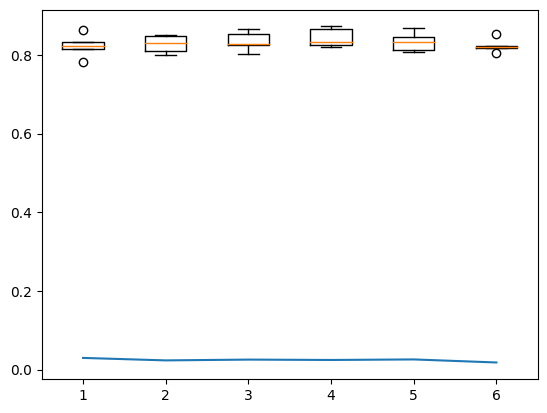

In [ ]:
plt.boxplot(df[df.columns]);
plt.plot([i for i in range(1, len(df.columns) + 1)], df.describe().transpose()["std"]);

We will show its mean and standar deviation too.

In [ ]:
df.describe().transpose()[["mean", "std"]]

,mean,std
"1(100, 100)",0.823313,0.029518
"1(200, 200)",0.827580,0.023223
"1(300, 300)",0.833994,0.025243
"2(100, 100)",0.843075,0.024292
"2(200, 200)",0.833340,0.025668
"2(300, 300)",0.823404,0.017919


We save the results in order to plot them together.

In [ ]:
folds = [["CMR" + r[0], *r[1]] for r in results.items()]
df = pd.read_csv("SSA_testing.csv")
_df = pd.DataFrame(folds, columns = df.columns)
df = pd.concat([df, _df])
df.to_csv("SSA_testing.csv", index = False)

Finally, we can plot an example of inference.

In [ ]:
db = DataBlock(blocks = (ImageBlock, MaskBlock(codes)),
               get_items = get_image_files,
               get_y = get_y_fn,
               splitter = FuncSplitter(lambda x: Path(x).parent.name == "train"),
               item_tfms = [Resize((480,640)), TargetMaskConvertTransform()],
               batch_tfms = Normalize.from_stats(*imagenet_stats)
              )

dls = db.dataloaders(path_images, bs = 4)
learner = unet_learner(dls, **learner_hparams).to_fp16()
learner = learner.load("CutMixRandom")

mask = learner.predict(dls.train_ds[6][0])
print(np.unique(mask[0]))
mask = PILImage.create(decodes(mask[0]))

/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[0 1 2 3 4]


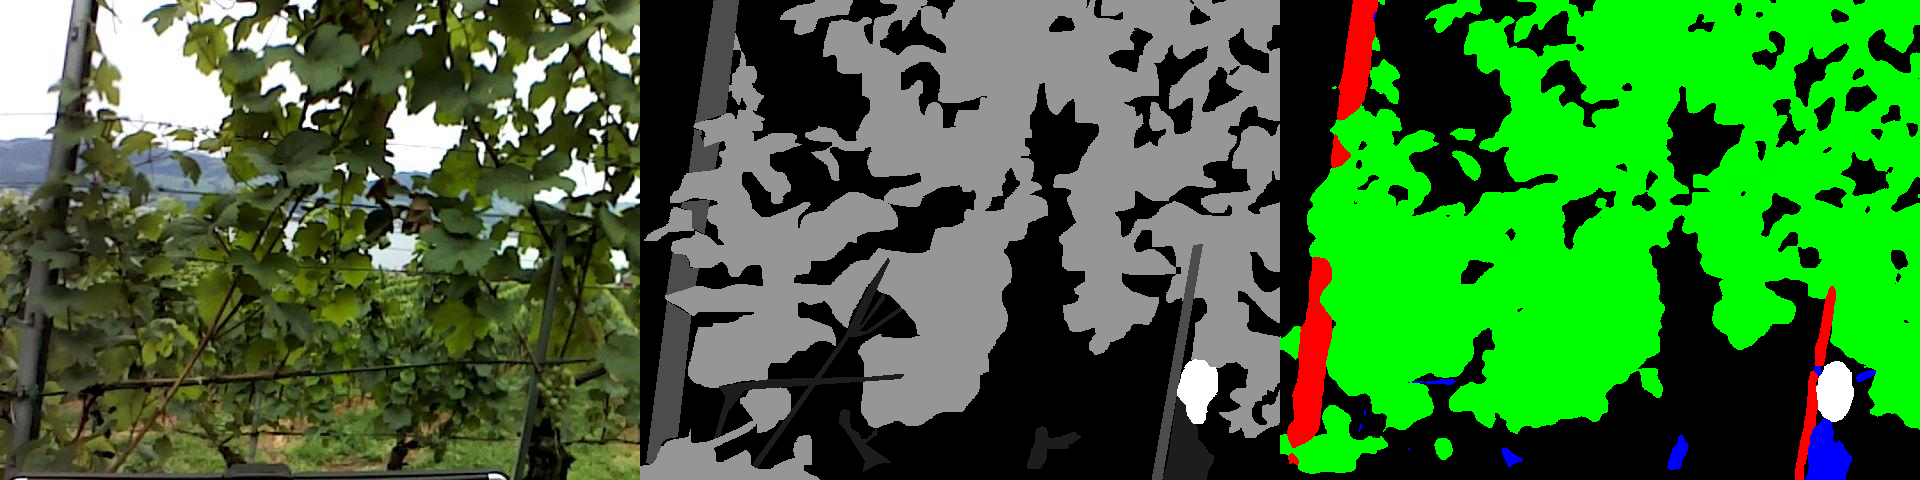

In [ ]:
image_grid([dls.train_ds[6][0], dls.train_ds[6][1], mask], rows = 1, cols = 3)

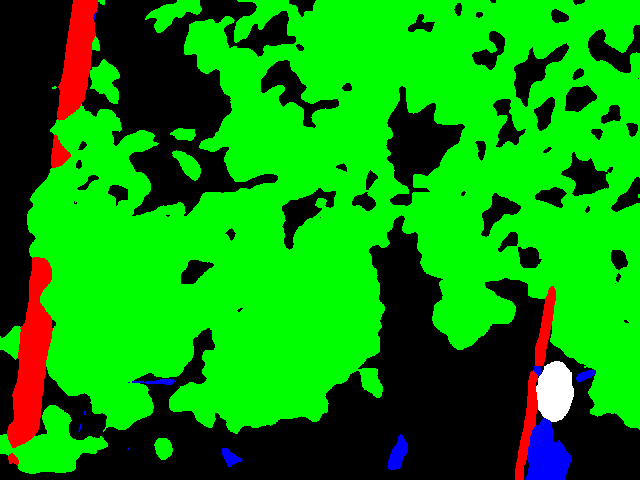

In [ ]:
mask